# PACKAGES

In [1]:
import get_data as gd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import Asset as a
import numpy as np
import random
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [53]:
#Grab bitcoin data
df_data = gd.grab_data()

# HYPERPARAMETER

In [24]:
# set some hyperparameters
NUMBER_OF_GENERATION = 3
POPULATION_SIZE = 2000
MUTATION_PROBABILITY = 0.3
HIGHEST_WINDOWSIZE = 30
LOWEST_WINDOWSIZE = 4
HIGHEST_HIGHTHRESHOLD = 90
LOWEST_HIGHRESHOLD = 60
HIGHEST_LOWTHRESHOLD = 50
LOWEST_LOWTHRESHOLD = 15
MUTATION_HIGH = 1.5
MUTATION_LOW = 0.67

#plotting hyperparams
N_COLS = 2
N_PLOTS = NUMBER_OF_GENERATION + 1
N_ROWS = (N_PLOTS + N_COLS - 1) // N_COLS

# TRADE STRATEGY

In [44]:
def apply_strategy(data, individual, start_time, end_time):
    # initialize some variables
    windowsize, highthreshold, lowthreshold = individual
    rsi = RSIIndicator(data["close"], window=windowsize)
    data["rsi"] = rsi.rsi()
    btc = np.asarray(data["close"])
    asset = a.Asset()
    in_position = False
    money_progress = []
    
    # apply buy and sell strategy
    for i in range(start_time, end_time + 1):
        # buy
        if not in_position and data["rsi"].iloc[i] < lowthreshold:
            asset.buy(btc[i + 1])
            in_position = True
        # sell
        elif in_position and data["rsi"].iloc[i] > highthreshold:
            asset.sell(btc[i + 1])
            in_position = False
        # store the value of money in each iteration
        money_progress.append(asset.money + asset.coin * btc[i + 1])

    if in_position:
        asset.sell(btc[-1])

    money_progress.append(asset.money)

    return money_progress

# calculate fitness of each individual
# def calculate_fitness(data, individual, start_time, end_time):
#     money_progress = apply_strategy(data, individual, start_time, end_time)
#     fitness = money_progress[-1] - 100
#     # if fitness is negative, set it to 0
#     return max(fitness, 0)
def calculate_fitness(data, individual, start_time, end_time):
    money_progress = apply_strategy(data, individual, start_time, end_time)
    score = money_progress[-1]
    return score

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# calculate the probability of each individual and select them as the parents of next generation
def roulette_wheel_selection(population, fitness):
    softmax_fitness = softmax(fitness)
    selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=softmax_fitness)
    return [population[i] for i in selected_indices]

# def roulette_wheel_selection(population, fitness):
#     total_fitness = sum(fitness)
#     if total_fitness == 0:
#         raise ValueError("The total fitness is 0, please try to run the program again.")
#     probabilities = [f / total_fitness for f in fitness]
#     selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=probabilities)
#     return [population[i] for i in selected_indices]

# PLOT

In [64]:
def draw_top_individuals(top_individuals, start_time, end_time, generation):
    # plot the money progress of the top 4 individuals in last generation
    color_list = ['r', 'b', 'g', 'k']
    subplot_location = generation // N_COLS,generation % N_COLS
    
    #plt.figure(figsize=(8, 4))
    for idx, (individual, fit) in enumerate(top_individuals[:4]):
        window, hight, lowt = individual
        days = range(start_time, end_time + 2)
        money_progress = apply_strategy(df_data, individual, start_time, end_time)
        axes[subplot_location].plot(days, money_progress, color=color_list[idx], 
                                    label=f"Individual {idx + 1}: | {window:02d} | {hight:03.2f} | {lowt:03.2f} |")
    axes[subplot_location].legend(loc='upper left')
    axes[subplot_location].set_title(f"Generation {generation + 1}" if generation != NUMBER_OF_GENERATION else 'Test Set')
    axes[subplot_location].set_xlabel("Day")
    axes[subplot_location].set_ylabel("Money(AUD)")
    # plt.savefig("figure/Top4IndividualsMoneyProgress.png")
    #plt.show()

# GENETIC ALGORITHM

In [45]:
def create_population(size):
    population = []
    # generate population by random parameters(genes)
    for _ in range(size):
        windowsize = random.randint(LOWEST_WINDOWSIZE, HIGHEST_WINDOWSIZE)
        highthreshold = random.uniform(LOWEST_HIGHRESHOLD, HIGHEST_HIGHTHRESHOLD)
        lowthreshold = random.uniform(LOWEST_LOWTHRESHOLD, HIGHEST_LOWTHRESHOLD)
        individual = (windowsize, highthreshold, lowthreshold)
        population.append(individual)
    return population

In [46]:
# crossover the parents to generate children
def crossover(parents):
    child1, child2 = parents
    crossover_point = random.randint(1, 2)
    child1 = child1[:crossover_point] + child2[crossover_point:]
    child2 = child2[:crossover_point] + child1[crossover_point:]
    return child1, child2

In [47]:
# mutate the children
def mutation(child):
    # set some variables about mutation
    mutation_prob = MUTATION_PROBABILITY
    mutated_gene_index = random.randint(0, 2)
    mutation_factor = random.uniform(MUTATION_LOW, MUTATION_HIGH)
    
    child = list(child)
    # if the random number is smaller than mutation probability, mutate the child
    if random.random() < mutation_prob:
        # mutate the gene by multiplying the mutation factor
        child[mutated_gene_index] *= mutation_factor
        # restrict the value of the gene
        if mutated_gene_index == 0:
            child[mutated_gene_index] = max(min(HIGHEST_WINDOWSIZE, int(child[mutated_gene_index])), LOWEST_WINDOWSIZE)
        elif mutated_gene_index == 1:
            child[mutated_gene_index] = max(min(HIGHEST_HIGHTHRESHOLD, child[mutated_gene_index]), LOWEST_HIGHRESHOLD)
        else:
            child[mutated_gene_index] = max(min(HIGHEST_LOWTHRESHOLD, child[mutated_gene_index]), LOWEST_LOWTHRESHOLD)

    return tuple(child)

In [65]:
def genetic_algorithm(data, start_time, end_time):
    # initialize the population
    population = create_population(POPULATION_SIZE)

    # run the algorithm for several generations
    for generation in range(NUMBER_OF_GENERATION):
        # calculate the fitness of each individual
        fitness = [calculate_fitness(data, individual, start_time, end_time) for individual in population]
        new_population = []

        # print the top 10 individuals and their fitness
        print('-' * 64)
        print(f"Generation {generation + 1}: Top 10 individuals and their fitness:")
        print('-' * 64)
        top_individuals = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)[:10]
        for individual, fit in top_individuals:
            window, hight, lowt = individual
            print(f"| {window:02d} | {hight:03.2f} | {lowt:03.2f} | Fitness: {fit:.2f}")
            
        draw_top_individuals(top_individuals, start_time, end_time, generation)

        # generate new population by crossover and mutation
        while len(new_population) < POPULATION_SIZE:
            parents = roulette_wheel_selection(population, fitness)
            child1, child2 = crossover(parents)
            child1 = mutation(child1)
            child2 = mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
    
    # return the top 10 individuals
    return top_individuals

The day from  400  to  499 days.
----------------------------------------------------------------
Generation 1: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 04 | 72.73 | 26.46 | Fitness: 158.76
| 05 | 67.86 | 29.25 | Fitness: 158.76
| 05 | 67.00 | 29.68 | Fitness: 158.76
| 07 | 63.53 | 43.24 | Fitness: 157.04
| 09 | 60.83 | 45.18 | Fitness: 155.43
| 13 | 60.87 | 29.60 | Fitness: 154.82
| 05 | 68.19 | 32.83 | Fitness: 153.55
| 05 | 68.73 | 33.01 | Fitness: 153.55
| 06 | 64.42 | 41.06 | Fitness: 153.04
| 06 | 64.53 | 34.93 | Fitness: 152.81
----------------------------------------------------------------
Generation 2: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 05 | 67.86 | 29.25 | Fitness: 158.76
| 04 | 72.73 | 28.84 | Fitness: 158.76
| 05 | 67.86 | 29.25 | Fitness: 158.76
| 05 | 67.86 | 29.25 | Fitness: 158.76
| 05 | 67.86 | 29.25 | Fitness: 158.76
| 05 | 67.00 | 29.

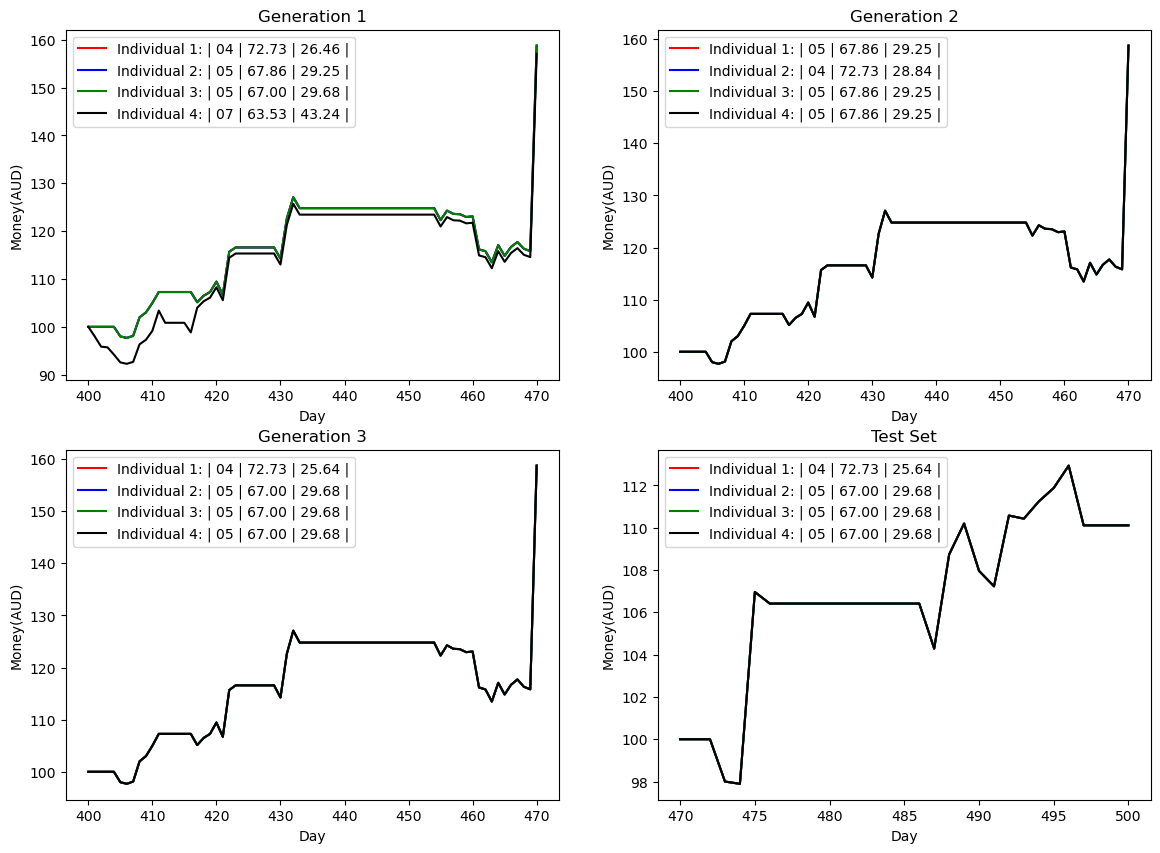




The day from  500  to  599 days.
----------------------------------------------------------------
Generation 1: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 12 | 68.01 | 49.54 | Fitness: 164.86
| 13 | 67.12 | 46.36 | Fitness: 164.15
| 16 | 64.34 | 46.26 | Fitness: 162.57
| 18 | 62.57 | 48.37 | Fitness: 162.57
| 12 | 67.78 | 48.63 | Fitness: 162.57
| 17 | 63.07 | 47.72 | Fitness: 162.57
| 16 | 63.43 | 49.19 | Fitness: 162.57
| 18 | 62.83 | 48.60 | Fitness: 162.57
| 14 | 65.51 | 48.76 | Fitness: 162.57
| 11 | 61.85 | 49.15 | Fitness: 162.25
----------------------------------------------------------------
Generation 2: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 12 | 68.01 | 50.00 | Fitness: 164.86
| 12 | 68.01 | 49.54 | Fitness: 164.86
| 13 | 67.12 | 50.00 | Fitness: 164.86
| 12 | 68.01 | 49.54 | Fitness: 164.86
| 12 | 68.01 | 49.54 | Fitness: 164.86
| 12 | 68.01 | 

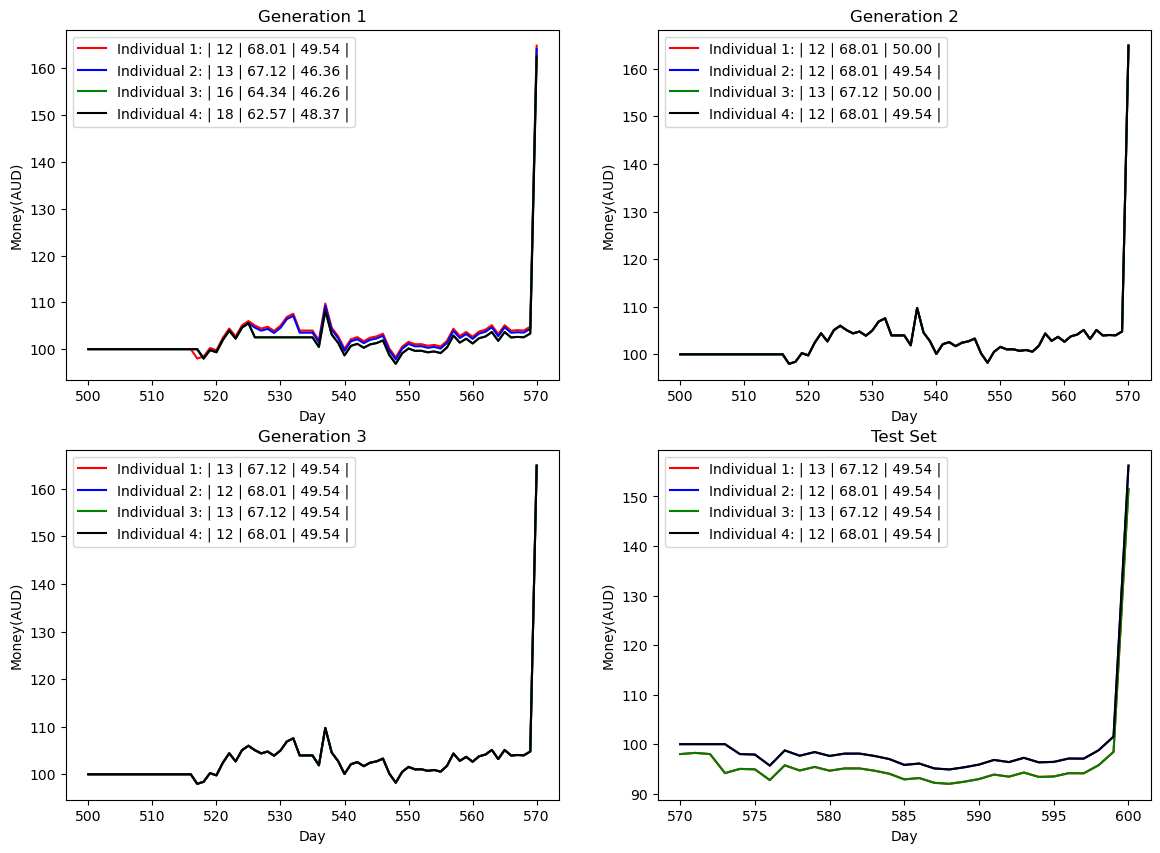




The day from  600  to  699 days.
----------------------------------------------------------------
Generation 1: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 29 | 68.88 | 46.57 | Fitness: 129.80
| 23 | 70.45 | 42.58 | Fitness: 129.80
| 26 | 63.19 | 45.24 | Fitness: 128.24
| 07 | 76.66 | 26.29 | Fitness: 128.24
| 08 | 71.97 | 22.35 | Fitness: 128.24
| 29 | 62.35 | 46.64 | Fitness: 128.24
| 28 | 62.07 | 49.35 | Fitness: 128.24
| 12 | 67.46 | 39.35 | Fitness: 128.24
| 10 | 69.50 | 35.29 | Fitness: 128.24
| 09 | 70.46 | 29.46 | Fitness: 128.24
----------------------------------------------------------------
Generation 2: Top 10 individuals and their fitness:
----------------------------------------------------------------
| 23 | 70.45 | 48.94 | Fitness: 129.80
| 29 | 68.88 | 46.57 | Fitness: 129.80
| 29 | 68.88 | 46.57 | Fitness: 129.80
| 29 | 68.88 | 46.57 | Fitness: 129.80
| 29 | 68.88 | 46.57 | Fitness: 129.80
| 29 | 68.88 | 

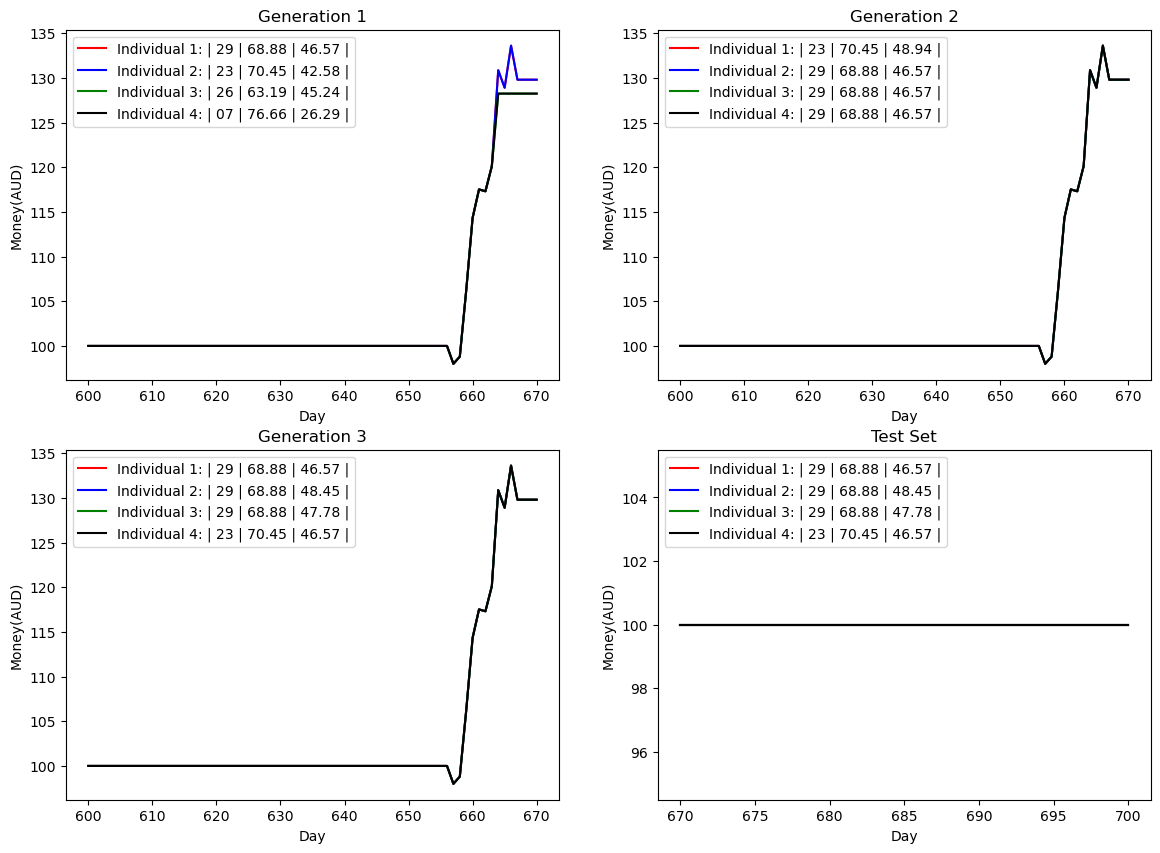

In [67]:
for i in range(4, 7):
    train_start_time = i * 100
    train_end_time = i * 100 + 69
    test_start_time = train_end_time + 1
    test_end_time = i * 100 + 99
    
    #subplot init
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(14, 10))
    
    print('The day from ', train_start_time, ' to ', test_end_time, 'days.')
    #train
    #print('------------------------train---------------------------')
    top_individuals = genetic_algorithm(df_data, train_start_time, train_end_time)
    # test
    #print('------------------------test---------------------------')
    draw_top_individuals(top_individuals, test_start_time, test_end_time, NUMBER_OF_GENERATION)
    plt.savefig(f"figure/{train_start_time}to{test_end_time}")
    plt.show()
    print()
    print()
    print()